In [1]:
import matplotlib.pylab as plt
import fitsio

Text(0.5,0,'$\\rm RA[deg.]$')

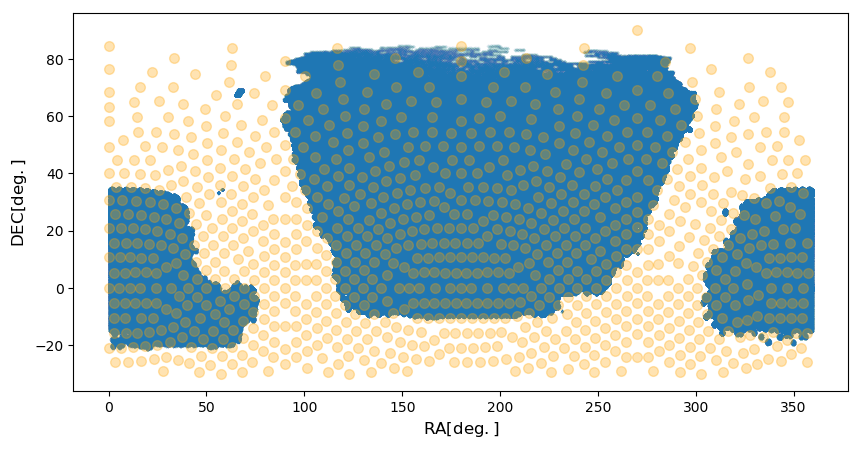

In [2]:
gfafile = '~/gfas-dr6.0-dr7.1-PR459.fits'

tilefile='~/ci-tiles-v2.fits'

citls,h=fitsio.read(tilefile,header=True)

gfa=fitsio.read(gfafile)

fig=plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(111)

plt.plot(gfa['RA'],gfa['DEC'],marker='.',linestyle='',markersize=0.1,alpha=0.1)

plt.plot(citls['RA'],citls['DEC'],marker='o',markersize=7,color='orange',alpha=0.3,linestyle='')

ax.set_ylabel(r'$\rm DEC[deg.]$', fontsize=12)
ax.set_xlabel(r'$\rm RA[deg.]$', fontsize=12)

In [3]:
import sys
import os
import os.path
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
from astropy.table import Table, Column 
import time
import datetime
from bokeh.plotting import *
from bokeh.embed import components
from bokeh.models import ColumnDataSource, LabelSet, HoverTool, Range1d, Label, TapTool, OpenURL, CustomJS, CrosshairTool, LinearAxis
import fitsio
from bokeh.io import output_notebook
import json
output_notebook()

#########################################################
gfafile = '~/gfas-dr6.0-dr7.1-PR459.fits'
tilefile='~/ci-tiles-v2.fits'
citls,h=fitsio.read(tilefile,header=True)
gfa=fitsio.read(gfafile)

with open("qa.json", "r") as read_file:
    data = json.load(read_file)

#########################################################
## Coloring scheme
palette = ['green', 'red', 'orange']
dye0 = []
for tile in citls['TILEID']:
    rang = 0 # Default value (green)
    if str(tile) in data:
        if len(data[str(tile)]['unassigned'])>0: # not assigned (red)
            rang = 1 #'red'
    else: rang = 2  # TileID is not available in the json file (orange)
    dye0.append(rang)

#########################################################
## Coloring scheme
dye1 = []
for tile in citls['TILEID']:
    rang = np.random.randint(3) # Default value (green)
    dye1.append(rang)
    
import copy 
dye = copy.deepcopy(dye0)

Loading BokehJS ...

In [4]:
from bokeh.models.widgets import RadioButtonGroup
from bokeh.layouts import column
from bokeh.models import CustomJS
from bokeh.transform import linear_cmap

TOOLS = ['pan', 'tap', 'wheel_zoom', 'box_zoom', 'reset', 'save']

p = figure(tools=TOOLS, toolbar_location="below", plot_width=900, plot_height=450)
p.title.text_font_size = '14pt'
p.title.text_color = 'green'
p.grid.grid_line_color="gainsboro"
    

N = len(gfa['RA'])
indx = [np.random.randint(N, size=10000)]
ras = gfa['RA'][indx]
decs= gfa['DEC'][indx]
background = ColumnDataSource({'RA': ras, 'DEC': decs})
pattern = p.circle('RA', 'DEC', source=background, size=15, color='lightsteelblue')
pattern.nonselection_glyph = None


mapper = linear_cmap(field_name='DYE', palette=palette, low=0 ,high=2)
tiles = ColumnDataSource({'RA': citls['RA'], 'DEC': citls['DEC'], 'TILEID': citls['TILEID'], 'DYE':dye, 'DYE0':dye0, 'DYE1':dye1})
render = p.circle('RA', 'DEC', source=tiles, size=9, line_color='chocolate', color=mapper, alpha=0.4, hover_color='red', hover_alpha=1, hover_line_color='red',
                    
                    # set visual properties for selected glyphs
                    selection_fill_color='red',
                    selection_line_color='red',
                    # set visual properties for non-selected glyphs
                    nonselection_fill_alpha=0.4,
                    nonselection_fill_color=mapper)


p.xaxis.axis_label = 'RA [deg]'
p.yaxis.axis_label = 'Dec. [deg]'
p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"
p.grid.grid_line_color="gainsboro"
p.yaxis.major_label_text_font_size = "12pt"
p.xaxis.major_label_text_font_size = "12pt"


## Javascript code to open up custom html pages, once user click on a tile
code = """
    var index_selected = source.selected['1d']['indices'][0];
    var tileID = source.data['TILEID'][index_selected];
    if (tileID!==undefined) {
    var win = window.open("http://www.astro.utah.edu/~u6022465/cmx/allSKY/tile-"+tileID+".html", "esn");
    try {win.focus();} catch (e){} }
"""

taptool = p.select(type=TapTool)
taptool.callback = CustomJS(args=dict(source=tiles), code=code)


## The html code for the hover window that contain tile infrormation
ttp = """
    <div>
        <div>
            <span style="font-size: 16px; color: blue;">Tile ID:</span>
            <span style="font-size: 16px; font-weight: bold;">@TILEID{int}</span>
        </div>
        <div>
            <span style="font-size: 16px; color: blue;">RA:</span>
            <span style="font-size: 16px; font-weight: bold;">@RA</span>
        </div>  
        <div>
            <span style="font-size: 16px; color: blue;">Dec:</span>
            <span style="font-size: 16px; font-weight: bold;">@DEC</span>
        </div>      
    </div>
"""


hover = HoverTool(tooltips=ttp, renderers=[render])

hover.point_policy='snap_to_data'
hover.line_policy='nearest'
#hover.mode='vline'
p.add_tools(hover)   

cross = CrosshairTool()
#cross.dimensions='height'
cross.line_alpha = 0.3
cross.line_color = 'green'
p.add_tools(cross) 

# Setting the second y axis range name and range
p.extra_y_ranges = {"foo": p.y_range}
p.extra_x_ranges = {"joo": p.x_range}

#Adding the second axis to the plot.  
p.add_layout(LinearAxis(y_range_name="foo"), 'right')
p.add_layout(LinearAxis(x_range_name="joo"), 'above')



radio_callback = CustomJS(args=dict(source=tiles), code="""
    var radio_value = cb_obj.active;
    var data = source.data;
    var dye = data['DYE'];
    var dye0 = data['DYE0'];
    var dye1 = data['DYE1'];
    if (radio_value=='0') {
        for (var i = 0; i < dye.length; i++) {
        dye[i] = dye0[i];
        } 
    } else if (radio_value=='1') {
        for (i = 0; i < dye.length; i++) {
        dye[i] = dye1[i];
        } 
    } else {
        for (i = 0; i < dye.length; i++) {
        dye[i] = 2;
        }     
    }
    
    source.change.emit();
""")


radio = RadioButtonGroup(
        labels=["Default", "Random", "Uniform"], active=0, callback=radio_callback)


layout = column(radio, p)
show(layout)
